<a href="https://colab.research.google.com/github/josephcabezas/Olist-Ecommerce-Data-Analysis/blob/main/python/olist_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database")

print("Path to dataset files:", path)

100%|██████████| 48.7M/48.7M [00:00<00:00, 59.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database/versions/1


In [8]:
import sqlite3

db_path = '/root/.cache/kagglehub/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database/versions/1/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [4]:
import pandas as pd

def view_table(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

In [9]:
# table orders, 5 rows, 3 columns
view_table('orders', 5).iloc[:, :3]

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered


In [11]:
# count number of daily orders
order_per_day = """
SELECT DATE(order_purchase_timestamp) AS day, COUNT(*) AS order_count
FROM orders
GROUP BY day
ORDER BY day
"""

df = pd.read_sql_query(order_per_day, db_connection)
df.head()

,day,order_count
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


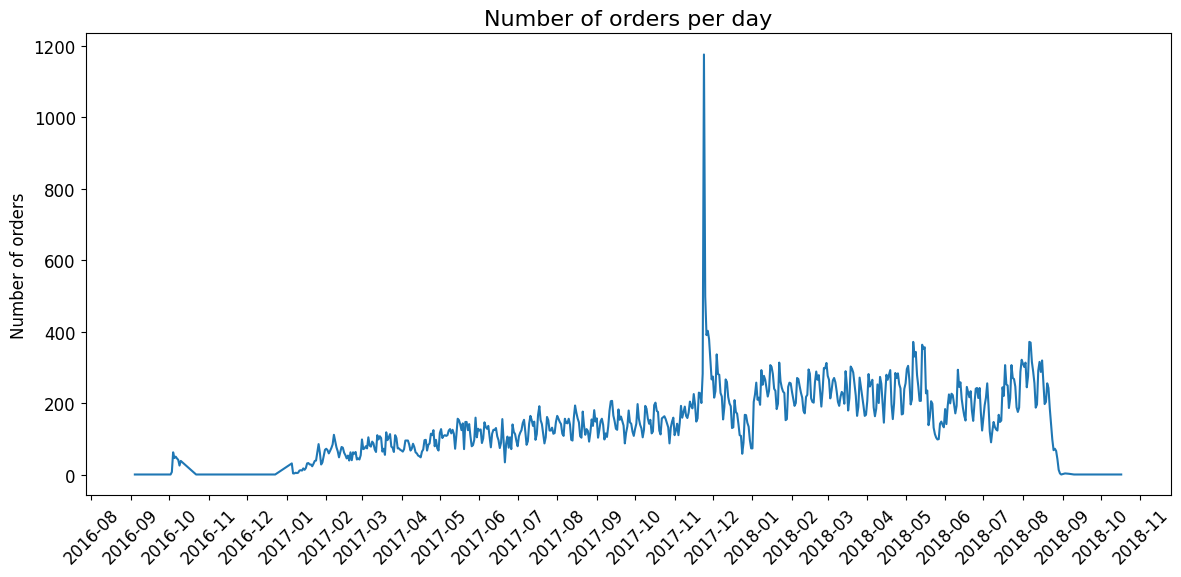

In [13]:
# data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase the default font size globally
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

# Line plot
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(df['day']), df['order_count'])
plt.ylabel('Number of orders')
plt.title('Number of orders per day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

- order spike around christmas

In [15]:
# how are orders distributed over the week
order_day_hour = """
SELECT
    -- abr days of week
    CASE strftime('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
        WHEN '0' THEN 'Sunday'
        END AS day_of_week_name,
    -- day of week as integer (sunday=7)
    CAST (strftime('%w', order_purchase_timestamp) AS INT) AS day_of_week_int,
    -- hour of the day (0-24)
    CAST (strftime('%H', order_purchase_timestamp) AS INT) AS hour
FROM orders
"""

pd.read_sql_query(order_day_hour, db_connection)

,day_of_week_name,day_of_week_int,hour
0,Monday,1,10
1,Tuesday,2,20
2,Wednesday,3,8
3,Saturday,6,19
4,Tuesday,2,21
...,...,...,...
99436,Thursday,4,9
99437,Tuesday,2,12
99438,Sunday,0,14
99439,Monday,1,21


In [17]:
count_orders_per_hour = ',\n    '.join([
    f'COUNT(CASE WHEN hour = {i} THEN 1 END) AS "{i}"' \
    for i in range(24)
])

orders_per_day_of_the_week_and_hour = f"""
WITH OrderDayHour AS (
    {order_day_hour}
)
SELECT
    day_of_week_name,
    {count_orders_per_hour}
FROM OrderDayHour
GROUP BY day_of_week_int
ORDER BY day_of_week_int
"""

df = pd.read_sql_query(orders_per_day_of_the_week_and_hour, db_connection)
df = df.set_index('day_of_week_name')
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week_name,,,,,,,,,,,,,,,,,,,,,
Sunday,267,141,69,44,27,27,34,105,205,349,...,684,716,712,797,895,899,967,889,873,607
Monday,328,134,66,36,21,22,69,160,479,783,...,1096,1079,1094,992,928,945,1027,1118,991,717
Tuesday,306,158,80,28,29,24,71,223,522,864,...,1124,1047,1081,967,877,924,988,1027,965,692
Wednesday,397,179,81,33,33,27,93,211,517,829,...,1050,983,1040,967,852,848,904,963,878,615
Thursday,355,167,75,39,31,28,85,220,502,758,...,977,928,1077,909,784,826,839,840,857,551
Friday,426,216,72,49,40,36,97,206,493,768,...,961,979,974,817,723,784,738,726,702,512
Saturday,315,175,67,43,25,24,53,106,249,434,...,677,722,697,701,710,756,730,654,550,429


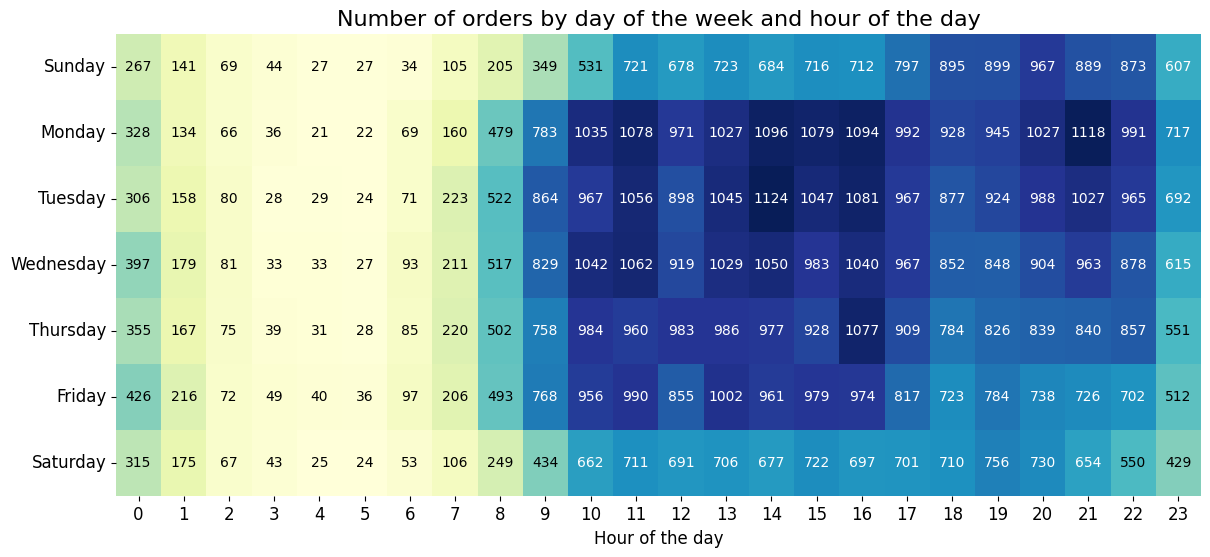

In [18]:
# data visualization, make heat map
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df, cmap='YlGnBu', cbar=False)
mean_orders = df.mean().mean()
for i in range(len(df)):
    for j in range(len(df.columns)):
        text_color = 'white' if df.iloc[i, j] > mean_orders else 'black'
        ax.text(j+0.5, i+0.5, int(df.iloc[i, j]),
            color=text_color, fontsize=10, ha="center", va="center")
plt.title("Number of orders by day of the week and hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("")
plt.show()

most orders from 10 am to 4 pm, with a slight dip during 12 pm lunch time. Saturday is the least busy day

In [19]:
view_table('customers', 5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [20]:
# what does the data say about cities?
orders_per_city = """
SELECT
    customer_city AS customer_city,
    UPPER(customer_city) AS city,
    COUNT(orders.order_id) as city_order_count
FROM
    customers
    JOIN orders USING (customer_id)
GROUP BY customer_city
ORDER BY city_order_count DESC
LIMIT 10
"""

pd.read_sql_query(orders_per_city, db_connection)

,customer_city,city,city_order_count
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


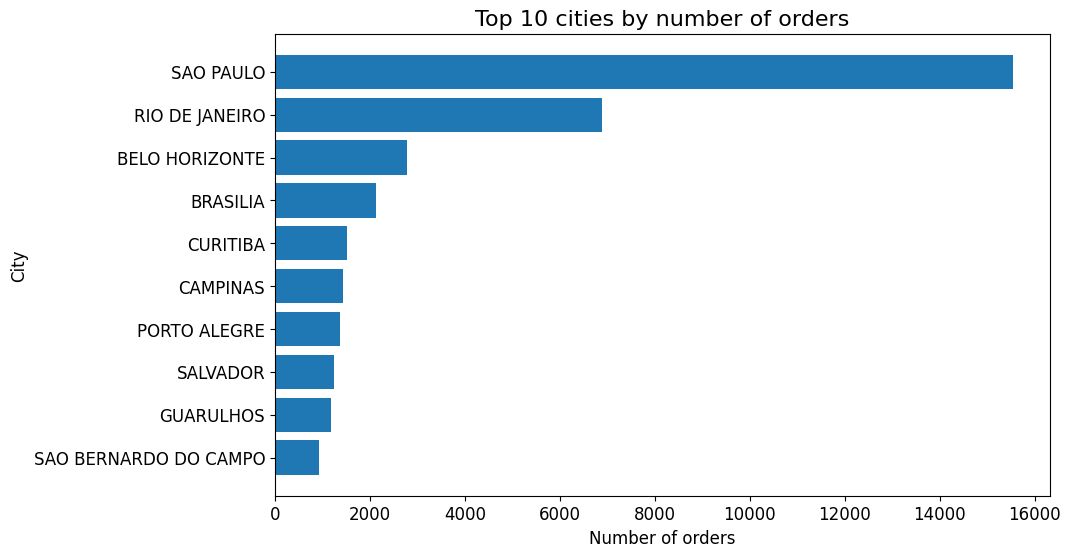

In [21]:
# data visualization
orders_per_city_reversed = f"""
SELECT *
FROM ({orders_per_city})
ORDER BY city_order_count
"""

top_cities = pd.read_sql_query(orders_per_city_reversed, db_connection)

plt.figure(figsize=(10, 6))
plt.barh(top_cities['city'], top_cities['city_order_count'])
plt.xlabel('Number of orders')
plt.ylabel('City')
plt.title('Top 10 cities by number of orders')
plt.show()

Sao Paulo and Rio De Janeiro have the most orders by far compared to other cities

In [22]:
view_table('order_items', 5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [24]:
# what's the average order price, incl shipping
order_price_stats = """
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(order_price_stats, db_connection)

,min_order_price,avg_order_price,max_order_price
0,9.59,160.58,13664.08


In [25]:
order_product_and_shipping_costs = """
SELECT
    orders.order_id,
    SUM(price) AS product_cost,
    SUM(freight_value) AS shipping_cost
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(order_product_and_shipping_costs, db_connection)
df

,order_id,product_cost,shipping_cost
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72


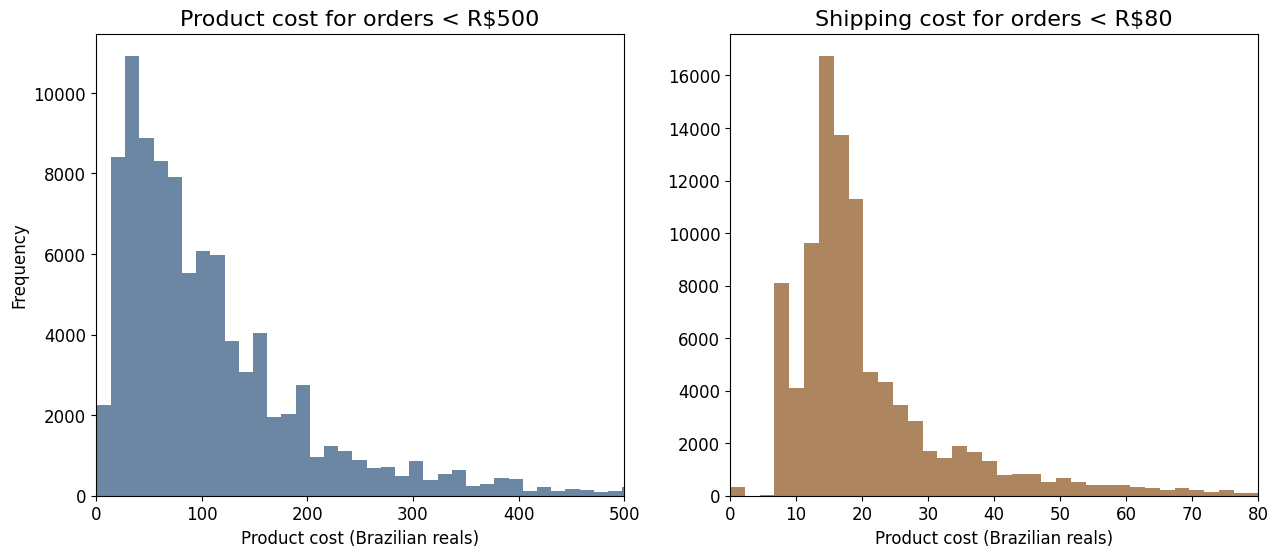

In [26]:
# data visualization
plt.figure(figsize=(15, 6))
# Histogram for total product cost
plt.subplot(1, 2, 1)
plt.hist(df['product_cost'], bins=1000, color='#6c87a3')
plt.title('Product cost for orders < R$500')
plt.xlabel('Product cost (Brazilian reals)')
plt.ylabel('Frequency')
plt.xlim([0, 500])
# Histogram for total shipping cost
plt.subplot(1, 2, 2)
plt.hist(df['shipping_cost'], bins=800, color='#ad865f')
plt.title('Shipping cost for orders < R$80')
plt.xlabel('Product cost (Brazilian reals)')
plt.xlim([0, 80])
plt.show()

In [27]:
view_table('products', 5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [28]:
ranked_categories = """
SELECT
    product_category_name_english AS category,
    SUM(price) AS sales,
    RANK() OVER (ORDER BY SUM(price) DESC) AS rank
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
"""

pd.read_sql_query(ranked_categories, db_connection)

,category,sales,rank
0,health_beauty,1233131.72,1
1,watches_gifts,1166176.98,2
2,bed_bath_table,1023434.76,3
3,sports_leisure,954852.55,4
4,computers_accessories,888724.61,5
...,...,...,...
66,flowers,1110.04,67
67,home_comfort_2,760.27,68
68,cds_dvds_musicals,730.00,69
69,fashion_childrens_clothes,519.95,70


In [29]:
# rank the top 17 categories, then group everything else in number 18
category_sales_summary = f"""
WITH RankedCategories AS (
    {ranked_categories}
)
-- Top 18 categories by sales
SELECT
    category,
    sales
FROM RankedCategories
WHERE rank <= 18
-- Other categories, aggregated
UNION ALL
SELECT
    'Other categories' AS category,
    SUM(sales) AS sales
FROM RankedCategories
WHERE rank > 18
"""

df = pd.read_sql_query(category_sales_summary, db_connection)
df

,category,sales
0,health_beauty,1233131.72
1,watches_gifts,1166176.98
2,bed_bath_table,1023434.76
3,sports_leisure,954852.55
4,computers_accessories,888724.61
5,furniture_decor,711927.69
6,housewares,615628.69
7,cool_stuff,610204.10
8,auto,578966.65
9,toys,471286.48


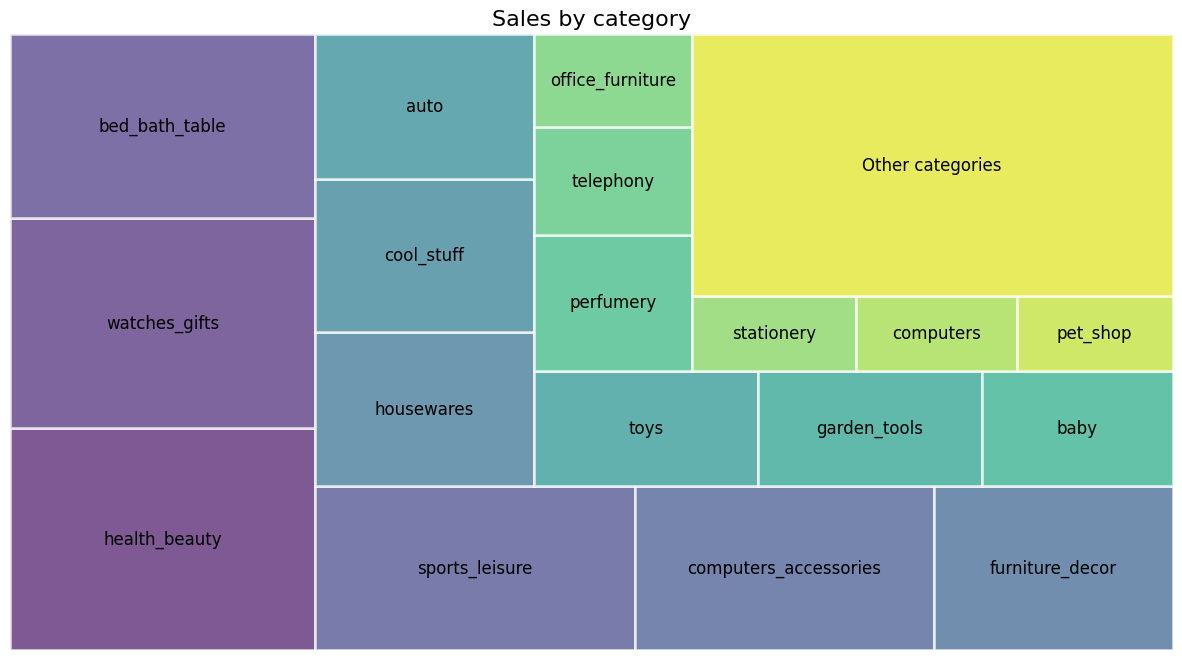

In [31]:
# data visualization
!pip install squarify
import squarify

plt.figure(figsize=(15, 8))
plt.title('Sales by category')
color = sns.color_palette("viridis", len(df))
squarify.plot(sizes=df['sales'], label=df['category'],
              alpha=0.7, color=color, edgecolor="white", linewidth=2)
plt.axis('off')
plt.show()

In [32]:
top_18_categories = tuple(category for category in df['category'] if category != 'Other categories')

In [33]:
ordered_categories = f"""
SELECT
    product_weight_g AS weight,
    product_category_name_english AS category,
    ROW_NUMBER() OVER(PARTITION BY product_category_name_english ORDER BY product_weight_g)
        AS category_row_n,
    COUNT(*) OVER(PARTITION BY product_category_name_english) AS category_count
FROM
    products
    JOIN order_items USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    product_category_name_english IN {top_18_categories}
"""

df = pd.read_sql_query(ordered_categories, db_connection)
df

,weight,category,category_row_n,category_count
0,50.0,auto,1,4235
1,50.0,auto,2,4235
2,50.0,auto,3,4235
3,50.0,auto,4,4235
4,50.0,auto,5,4235
...,...,...,...,...
92419,15267.0,watches_gifts,5987,5991
92420,15267.0,watches_gifts,5988,5991
92421,15267.0,watches_gifts,5989,5991
92422,17175.0,watches_gifts,5990,5991


In [34]:
categories_by_median = f"""
WITH OrderedCategories AS (
    {ordered_categories}
)
SELECT category
FROM OrderedCategories
WHERE
    -- Odd number of products: Select the middle row
    (category_count % 2 = 1 AND category_row_n = (category_count + 1) / 2) OR
    -- Even number of products: Select the two middle rows to be averaged
    (category_count % 2 = 0 AND category_row_n IN ((category_count / 2), (category_count / 2 + 1)))
GROUP BY category
ORDER BY AVG(weight)
"""

categories_by_median_df = pd.read_sql_query(categories_by_median, db_connection)
categories_by_median_df

,category
0,telephony
1,computers_accessories
2,watches_gifts
3,health_beauty
4,perfumery
5,baby
6,sports_leisure
7,toys
8,pet_shop
9,auto


<ipython-input-37-4bd761771210>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weight', y='category', data=df, order=order, palette='deep', showfliers=False)


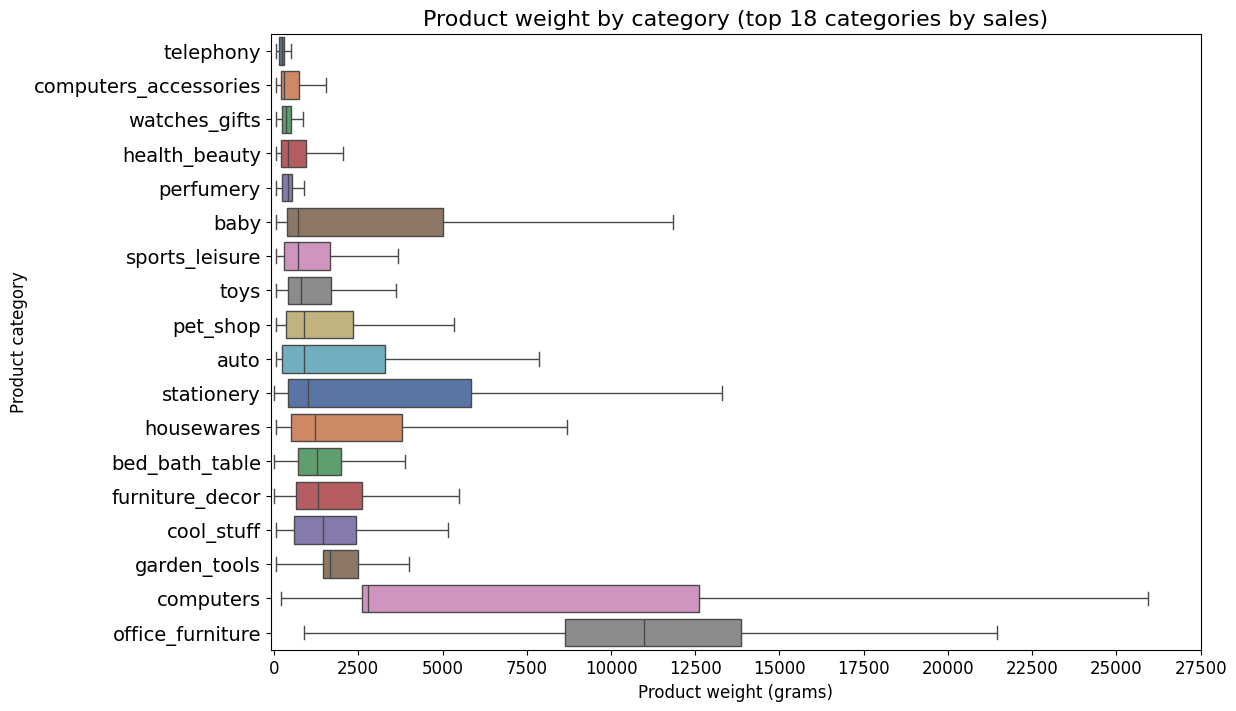

In [37]:
# data visualization, box plots
plt.figure(figsize=(12, 8))
order = categories_by_median_df['category'].tolist()
sns.boxplot(x='weight', y='category', data=df, order=order, palette='deep', showfliers=False)
plt.xlabel('Product weight (grams)')
plt.ylabel('Product category')
plt.title('Product weight by category (top 18 categories by sales)')
plt.xlim(-100, 26100)
plt.xticks(ticks=range(0, 30000, 2500))
plt.yticks(fontsize=14)
plt.show()

In [38]:
# sales prediction
selected_categories = ('health_beauty', 'auto', 'toys', 'electronics', 'fashion_shoes')

In [39]:
monthly_sales_selected_categories = f"""
SELECT
    strftime('%Y-%m', order_purchase_timestamp) AS year_month,
    SUM(CASE WHEN product_category_name_english = 'health_beauty' THEN price END) AS health_beauty,
    SUM(CASE WHEN product_category_name_english = 'auto' THEN price END) AS auto,
    SUM(CASE WHEN product_category_name_english = 'toys' THEN price END) AS toys,
    SUM(CASE WHEN product_category_name_english = 'electronics' THEN price END) AS electronics,
    SUM(CASE WHEN product_category_name_english = 'fashion_shoes' THEN price END) AS fashion_shoes
FROM orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_purchase_timestamp >= '2017-01-01'
    AND product_category_name_english IN {selected_categories}
GROUP BY year_month
"""

df = pd.read_sql_query(monthly_sales_selected_categories, db_connection)
df = df.set_index('year_month')
df

,health_beauty,auto,toys,electronics,fashion_shoes
year_month,,,,,
2017-01,12561.32,5218.53,4814.09,617.00,34.90
2017-02,22838.79,13162.40,9403.34,1218.85,107.05
2017-03,25995.25,14482.07,12429.47,3986.00,1515.00
2017-04,22935.75,15548.17,13039.43,4822.24,1526.50
2017-05,46786.02,18640.03,22626.95,6709.11,1669.54
2017-06,32029.39,31370.69,15476.35,2100.04,1351.20
2017-07,34896.86,14119.74,24511.72,7346.84,1423.01
2017-08,49873.90,20421.11,18126.87,2854.15,1491.69
2017-09,51537.65,14544.67,31399.22,4338.96,1179.60


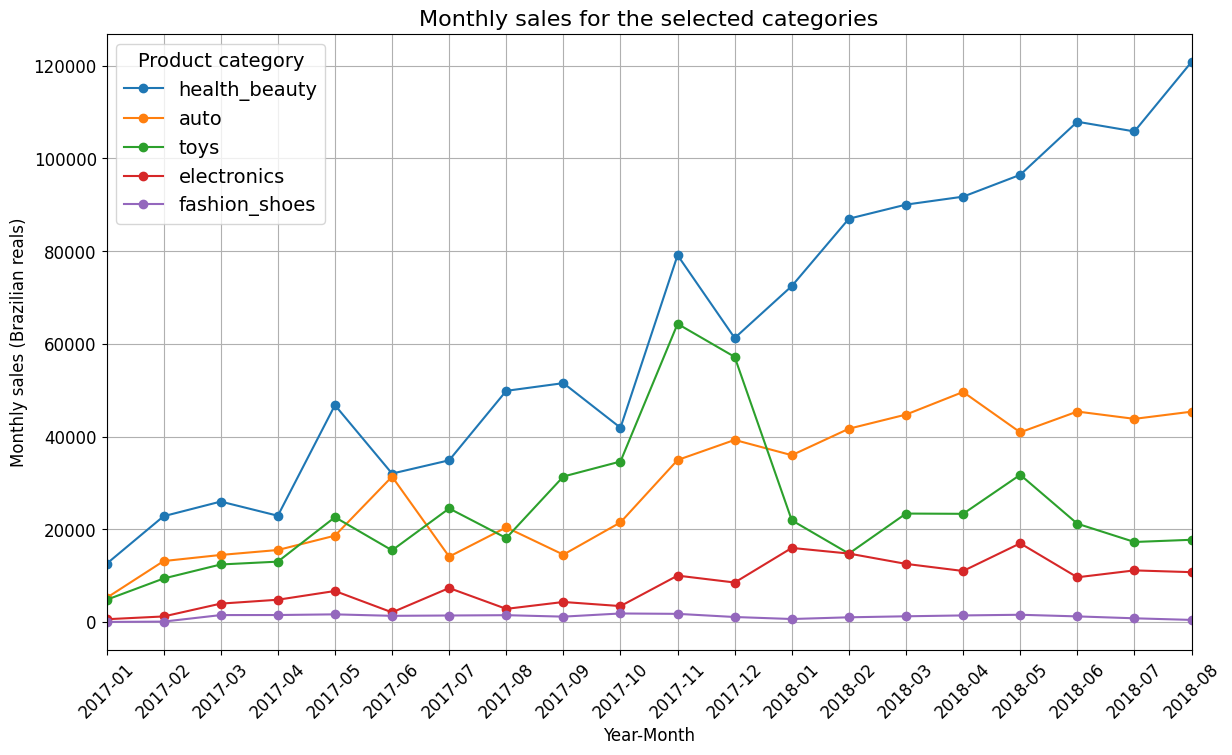

In [40]:
# data visualization
df.index = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(14, 8))
df.plot(ax=ax, marker='o', linestyle='-')
ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%Y-%m'), rotation=90)
plt.title('Monthly sales for the selected categories')
plt.xlabel('Year-Month')
plt.ylabel('Monthly sales (Brazilian reals)')
plt.xticks(rotation=45)
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

health and beauty has consistenly been the top selling category. Categories like health and beauty, auto, and electronics are experiencing boom growth. Toys booms during the holidays but then sharply falls. Fashion shoes has been very stagnant.

In [41]:
daily_sales_per_category = f"""
SELECT
    DATE(order_purchase_timestamp) AS date,
    -- Days since 2017-01-01
    CAST(JULIANDAY(order_purchase_timestamp) - JULIANDAY('2017-01-01') AS INTEGER) AS day,
    product_category_name_english AS category,
    SUM(price) AS sales
FROM
    orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    order_purchase_timestamp BETWEEN '2017-01-01' AND '2018-08-29'
    AND category IN {selected_categories}
GROUP BY
    day,
    product_category_name_english
"""

df = pd.read_sql_query(daily_sales_per_category, db_connection)
df

,date,day,category,sales
0,2017-01-05,4,auto,21.80
1,2017-01-05,4,toys,43.80
2,2017-01-06,5,health_beauty,636.00
3,2017-01-06,5,toys,159.99
4,2017-01-07,6,health_beauty,370.00
...,...,...,...,...
2440,2018-08-27,603,auto,343.38
2441,2018-08-27,603,health_beauty,661.50
2442,2018-08-27,603,toys,257.79
2443,2018-08-28,604,auto,124.00


In [42]:
# set up linear regression
daily_sales_per_category = f"""
SELECT
    DATE(order_purchase_timestamp) AS date,
    -- Days since 2017-01-01
    CAST(JULIANDAY(order_purchase_timestamp) - JULIANDAY('2017-01-01') AS INTEGER) AS day,
    product_category_name_english AS category,
    SUM(price) AS sales
FROM
    orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    order_purchase_timestamp BETWEEN '2017-01-01' AND '2018-08-29'
    AND category IN {selected_categories}
GROUP BY
    day,
    product_category_name_english
"""

pd.read_sql_query(daily_sales_per_category, db_connection)

,date,day,category,sales
0,2017-01-05,4,auto,21.80
1,2017-01-05,4,toys,43.80
2,2017-01-06,5,health_beauty,636.00
3,2017-01-06,5,toys,159.99
4,2017-01-07,6,health_beauty,370.00
...,...,...,...,...
2440,2018-08-27,603,auto,343.38
2441,2018-08-27,603,health_beauty,661.50
2442,2018-08-27,603,toys,257.79
2443,2018-08-28,604,auto,124.00


In [44]:
lm_per_category = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
)
SELECT
    category,
    -- Slope
    (COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) /
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))
        AS slope,
    -- Intercept
    (SUM(sales) -
        ((COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) /
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))) *
        SUM(day)) / COUNT(*)
        AS intercept
FROM
    DailySalesPerCategory
GROUP BY
    category
"""

df = pd.read_sql_query(lm_per_category, db_connection)
df

,category,slope,intercept
0,auto,2.257831,319.055318
1,electronics,0.614535,105.302974
2,fashion_shoes,0.126815,89.637179
3,health_beauty,5.876734,305.451543
4,toys,0.563910,649.648518


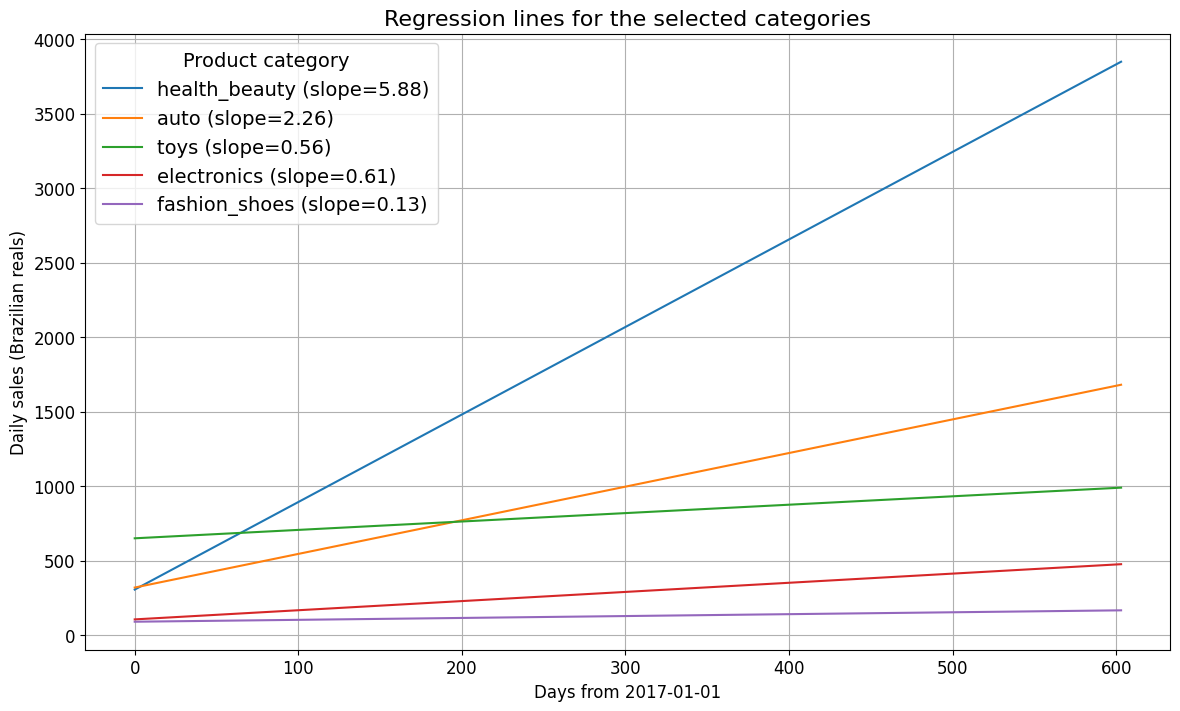

In [46]:
# data visualization
import numpy as np

plt.figure(figsize=(14, 8))
days = np.arange(0, 604)
for category in selected_categories:
    lm = df[df['category'] == category]
    slope = lm['slope'].values[0]
    intercept = lm['intercept'].values[0]
    line = intercept + slope * days
    plt.plot(days, line, label=f'{category} (slope={slope:.2f})')
plt.title('Regression lines for the selected categories')
plt.xlabel('Days from 2017-01-01')
plt.ylabel('Daily sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

In [47]:
# sales forecast
forecasted_sales_dec_2018 = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
),
LmPerCategory AS (
    {lm_per_category}
),
ForecastedSales AS (
    SELECT
        DATE(date, '+1 year') AS date,
        category,
        -- Increase in predicted sales * sales 1 year ago
        (intercept + slope * (day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)))
            / (intercept + slope * day) * sales
            AS forecasted_sales
    FROM DailySalesPerCategory
        JOIN LmPerCategory USING (category)
    -- Filter for days of December 2018
    WHERE day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)
        BETWEEN CAST(JULIANDAY('2018-12-01') - JULIANDAY('2017-01-01') AS INTEGER)
        AND CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-01-01') AS INTEGER)
)
SELECT
    CAST(strftime('%d', date) AS INTEGER) AS december_2018_day,
    category,
    -- 5-day moving average
    AVG(forecasted_sales)
        OVER (PARTITION BY category ORDER BY date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING)
        AS moving_avg_sales
FROM ForecastedSales
"""

forecast_2018_12_df = pd.read_sql_query(forecasted_sales_dec_2018, db_connection)
forecast_2018_12_df

,december_2018_day,category,moving_avg_sales
0,1,auto,2438.257278
1,2,auto,2957.096207
2,3,auto,2612.112277
3,4,auto,3034.655653
4,5,auto,2919.956942
...,...,...,...
126,27,toys,1247.841517
127,28,toys,857.343323
128,29,toys,585.209963
129,30,toys,621.773116


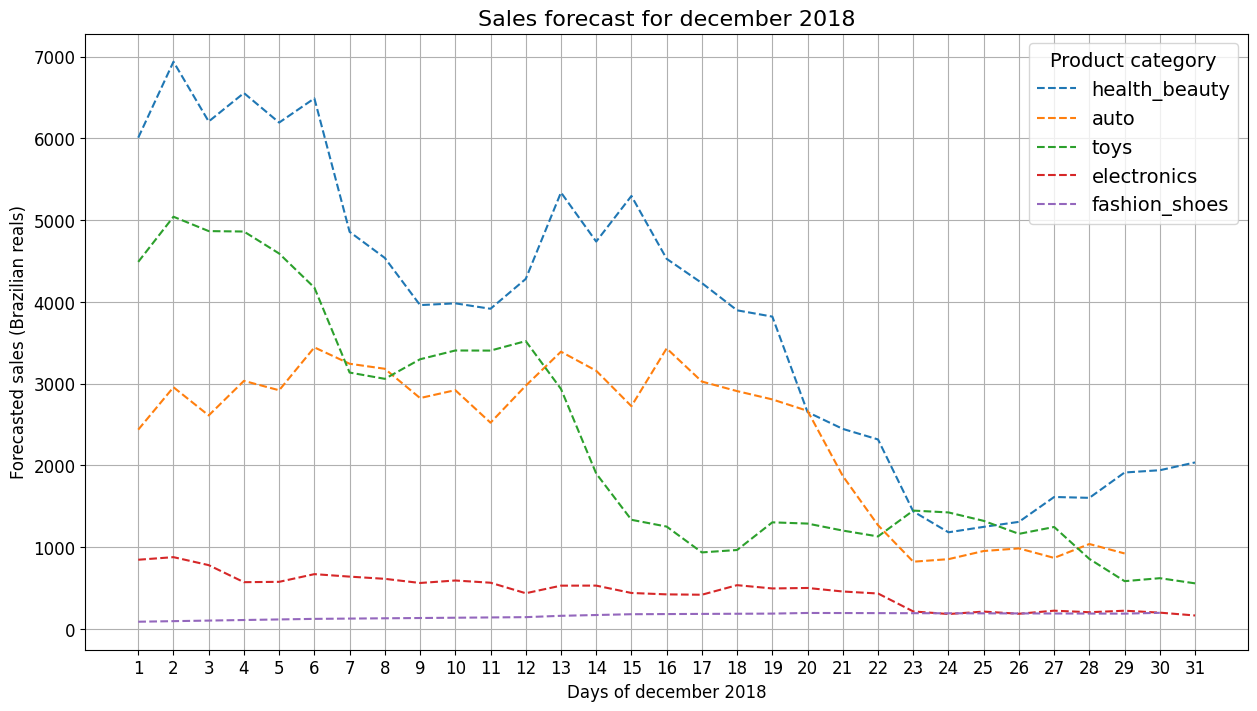

In [48]:
# data visualization
plt.figure(figsize=(15, 8))
for category in selected_categories:
    category_forecast = forecast_2018_12_df[forecast_2018_12_df['category'] == category]
    plt.plot(category_forecast['december_2018_day'], category_forecast['moving_avg_sales'], '--', label=category)
plt.title('Sales forecast for december 2018')
plt.xlabel('Days of december 2018')
plt.ylabel('Forecasted sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.xticks(range(1, 32))
plt.show()

the model predicts that health and beauty will be the highest selling category of the five we examined, and its sales will slowly go down until Christmas. toys will have strong sales for the first two weeks but decline sharply after that. auto sales remain stable for the first 3 weeks, but they'll go down afterward. electronics follows a similar trend but fashion_shoes sales seem to be independent of the holiday trends, increasing slightly at the end of the month.

In [49]:
order_stage_times_top_10_citites = f"""
SELECT
    UPPER(customer_city)
        AS city,
    AVG(JULIANDAY(order_approved_at) - JULIANDAY(order_purchase_timestamp))
        AS approved,
    AVG(JULIANDAY(order_delivered_carrier_date) - JULIANDAY(order_approved_at))
        AS delivered_to_carrier,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_delivered_carrier_date))
        AS delivered_to_customer,
    AVG(JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_delivered_customer_date))
        AS estimated_delivery
FROM orders
    JOIN customers USING (customer_id)
WHERE  customer_city IN {tuple(top_cities['customer_city'])}
GROUP BY  customer_city
ORDER BY approved + delivered_to_carrier + delivered_to_customer DESC
"""

df = pd.read_sql_query(order_stage_times_top_10_citites, db_connection)
df = df.set_index('city')
df

,approved,delivered_to_carrier,delivered_to_customer,estimated_delivery
city,,,,
SALVADOR,0.498863,2.700868,16.160566,8.755085
PORTO ALEGRE,0.420697,2.809786,12.786769,11.091915
RIO DE JANEIRO,0.383342,2.979133,11.409813,12.504991
BRASILIA,0.432585,2.762064,9.805472,11.333709
BELO HORIZONTE,0.378608,2.848813,7.900486,11.901479
CURITIBA,0.453929,2.690824,7.316206,12.732135
CAMPINAS,0.420262,2.784653,6.611740,8.821432
SAO BERNARDO DO CAMPO,0.349693,2.702651,5.045101,9.799631
SAO PAULO,0.385928,2.726784,4.961921,10.027349


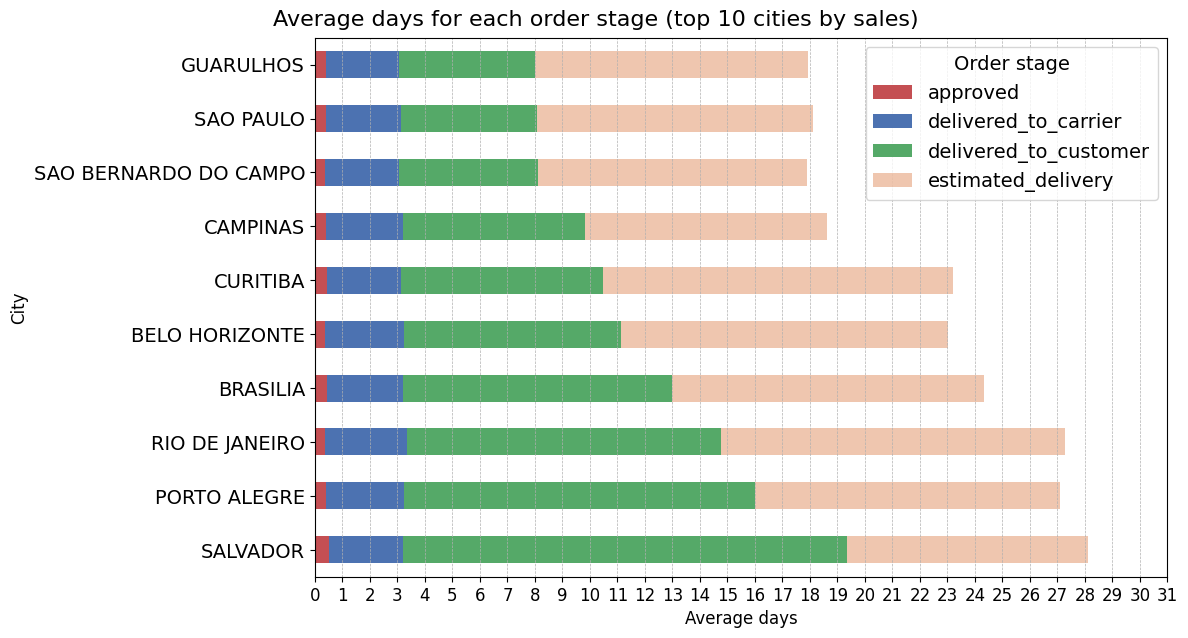

In [50]:
# data visualization
fig, ax = plt.subplots(figsize=(11, 7))
df.plot(kind='barh', stacked=True, color=['#c44f53', '#4c72b1', '#55a968', '#dd845275'], ax=ax)
ax.set_xlabel('Average days')
ax.set_ylabel('City')
fig.suptitle('Average days for each order stage (top 10 cities by sales)', fontsize=16, x=0.38, y=0.92)
ax.grid(True, linestyle='--', linewidth=0.5, axis='x')
max_bar_length = int(df.sum(axis=1).max())
ax.set_xticks(range(0, max_bar_length + 4))
ax.tick_params(axis='y', labelsize=14)
plt.legend(title='Order stage', title_fontsize=14, fontsize=14)
plt.show()

varying shipping times. Sao Paulo being the second quickest is great because it has the highest order volume. However, it is troubling seeing Rio De Janeiro so slow when it has the second highest order volume

In [ ]:
# is there a seasonal variation in shipping times
